In [35]:
from nltk.corpus import wordnet, words
import nltk
import re
import json
from nltk.sentiment import SentimentIntensityAnalyzer
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#loading data 
with open('./data/manywords_pos.txt') as f:
    manywords_pos = f.read()
    exec(f'manywords_pos = {manywords_pos}') #convert the string to original list

graphs = dict.fromkeys(('n','v','a','s','r'))
eigs = dict.fromkeys(('n','v','a','s','r'))
for g in graphs.keys():
    with open(f'./data/syn_graph/syn_graph_{g}.json','r') as f:
        graphs[g] = json.load(f)
    
    with np.load(f'data/syn_graph/eigs_{g}.npz') as data:
        eigs[g] = data['eigs']

## Synonym Net

- find networks for each part of speech, see if they are organized in dense node clusters
- color nodes by sentiment (make it just binary good/bad for now), and observe any "gradients"
    - how easy is it (or "how short of a walk is it") to go from one polar sentiment to the next?
- degree distr

Networks visualized in HTML files

Synset methods: .name, .pos

Preprocessing:
- don't want VBD (past tense) or VBG (gerund or past particple) as this is redundant
- This is removing some wrong things e.g barefooted ("I barefooted" makes it VBD) when it's an adj

Quick guides:
    
    n NOUN

    v VERB

    a ADJECTIVE

    s ADJECTIVE SATELLITE

    r ADVERB

In [234]:
# Collecting all words
# some functions to search words for undesirable properties
def has_undesirable(inputStr):
    total_bool = bool(re.search(r'\d', inputStr)) or any(not c.isalnum() for c in inputStr) or any(c.isupper() for c in inputStr) or len(inputStr) ==1
    return total_bool

manywords = words.words() + list(wordnet.words())
manywords = list(dict.fromkeys(manywords)) #remove duplicates
#df = pd.read_csv('./data/all_words.txt', sep=' ', header=None) #just words
manywords = [i for i in manywords if has_undesirable(i) == False]

In [235]:
# assigning words their (potentially) multiple parts of speech
pos_map = {'NN':'n', 'VB':'v', 'JJ':'a'} #for mapping words w/o syns
manywords_pos = [] #[(word1, pos), ...]
for w in manywords:
    if nltk.pos_tag(['I',w])[1][1] == 'VBD' or nltk.pos_tag([w])[0][1] == 'VBG': # hack to tell if this is a redundant word. First case guarantees it is in fact a VBD, 
        continue                                                                 # second case uses only the word for cases like 'passing' (which can be NN)
        
    syns = wordnet.synsets(w)
    if len(syns) > 0:
        word_pos = [] # [(word,pos1),...,(word,posN)]
        psos = list(dict.fromkeys([s.pos() for s in syns])) # duplicates removed parts of speech
        for pos in psos:
            word_pos.append((w,pos))
        for wp in word_pos:
            manywords_pos.append(wp)
    else:
        pos = nltk.pos_tag([w])[0][1]
        try:
            pos = pos_map[pos]
            manywords_pos.append((w,pos))
        except:
            continue
            
with open('./data/manywords_pos.txt', 'w') as f:
    f.write(str(manywords_pos))

In [236]:
pos_subsets = dict.fromkeys(('n','v','a','s','r'))
for pos in pos_subsets.keys():
    pos_subset = [(w,p) for (w,p) in manywords_pos if p == pos]
    pos_subsets[pos] = pos_subset
    
polarity_done = False #if it was done previously
SIA = SentimentIntensityAnalyzer()
graphs = dict.fromkeys(pos_subsets.keys())
non_sentim = []
for g in graphs.keys():
    graphs[g] = {'nodes' : [],'edges' : []}

for pos in graphs.keys():
    edges_cache = []
    for (w,p) in pos_subsets[pos]:
        wp = f'{w}.{p}' 
        syns = [syn for syn in wordnet.synsets(w) 
                        if syn.pos() == p #right POS
                        and syn.name()[:syn.name().index('.')] != wp[:-2] #is not the same word
                        and '_' not in syn.name()] #no non-single words
        #nodes
        if not polarity_done:
            scores = SIA.polarity_scores(w); del scores['compound']
            try:
                sentm = [key for key in scores.keys() if scores[key] == 1.0][0]
                graphs[pos]['nodes'].append({**{"word":wp}, **{'sentm':sentm}})
                #edges
                for syn in syns:
                    syn = syn.name()[:-3] #removing number at end; maybe revise later to ensure no significant loss
                    if {wp,syn} not in edges_cache and tuple(syn.split('.')) in pos_subsets[pos]: # since underiected graph
                        edges_cache.append({wp,syn})
                        graphs[pos]['edges'].append({"source":wp,"target":syn})
            except:
                non_sentim.append(wp)
                continue
            
        else:
            pass #todo
    with open(f'./data/syn_graph/syn_graph_{pos}.json','w') as f:
        json.dump(graphs[pos],f,indent=4)

# Degree distributions and spectra
- This kind of thing https://www.wikiwand.com/en/Algebraic_connectivity<br>
Adjective rankings are really weird; NLTK synsets are maybe a weak API for synonyms. Is this due to lazy manual labeling (see example in misc?

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


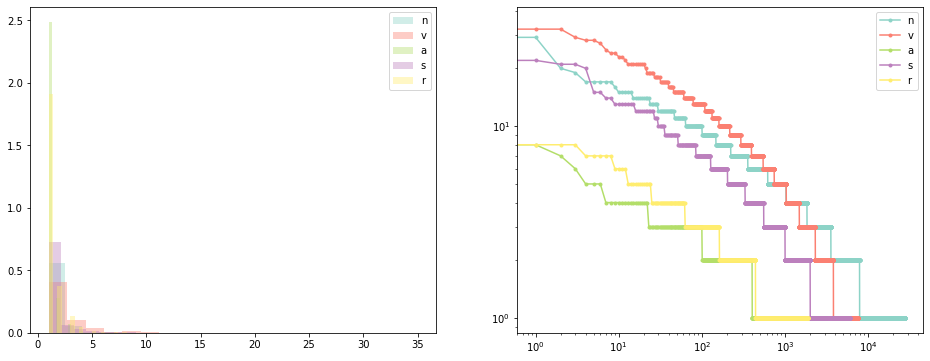

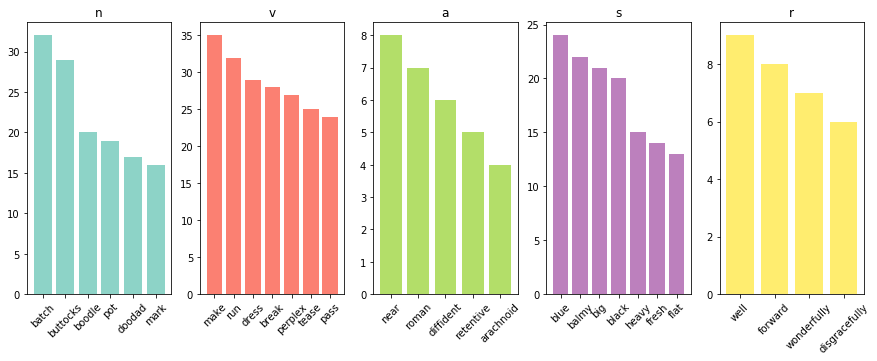

In [328]:
plt.figure(figsize=(16,6))
colors = list(iter(plt.cm.Set3(np.linspace(0, 1, 5))))
topwords = dict.fromkeys(graphs.keys())
adj_mats = dict.fromkeys(graphs.keys())
for i, g in enumerate(graphs.keys()):
    nx_format = [tuple(edge.values()) for edge in graphs[g]['edges']]
    nx_graph = nx.Graph(nx_format)
    degrees = dict(nx_graph.degree)
    deg_rev_sort = sorted(list(degrees.values()), reverse = 1)
    plt.subplot(1,2,1)
    #norm hist by max degree
    y, x, _ = plt.hist(np.array(list(degrees.values())),bins=20,label=g,alpha=0.4,density=True,stacked=True, color = colors[i]); plt.legend()
    plt.subplot(1,2,2)
    plt.loglog(list(range(len(nx_graph))), deg_rev_sort, '.-',label = g, color = colors[i]); plt.legend()
    
    #degree ranking chart
    invmap = {v: k for k, v in degrees.items()}
    maxwrds = []
    for d in deg_rev_sort[:10]:
        maxwrds.append(invmap[d])
    maxwrds = [i.split('.')[0] for i in maxwrds]
    topwords[g] = ( maxwrds, deg_rev_sort[:10],)  
    
plt.figure(figsize=(15,5))
for i,g in enumerate(topwords.keys()):
    plt.subplot(1,5,i+1)
    plt.title(g)
    plt.bar(topwords[g][0],topwords[g][1],color=colors[i])
    plt.xticks(rotation=45)

In [ ]:
for g in graphs.keys():
    nx_format = [tuple(edge.values()) for edge in graphs[g]['edges']]
    nx_graph = nx.Graph(nx_format)
    laplacian = nx.linalg.laplacianmatrix.laplacian_matrix(nx_graph).todense()
    eigs, _ = np.linalg.eig(laplacian)
    np.savez(f'data/syn_graph/eigs_{g}.npz',eigs=eigs)

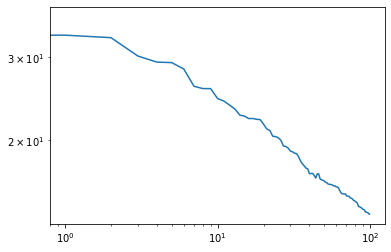

In [14]:
plt.loglog(range(len(eigs[:100])),eigs[:100])

# Misc, data cleaning
- Some example of perplexing noise in synsets:<br>
`>>> wordnet.synsets('assess')`
```
[Synset('buttocks.n.01'),
 Synset('ass.n.02'),
 Synset('ass.n.03'),
 Synset('fuck.n.01'),
 Synset('measure.v.04'),
 Synset('assess.v.02'),
 Synset('tax.v.02'),
 Synset('assess.v.04')]
```

Also, some synonyms appear in synsets but not the other way around, though this should not affect the fact that this is an undirected graph too much

In [6]:
nx_format = [tuple(edge.values()) for edge in graphs['v']['edges']]
nx_graph = nx.Graph(nx_format)
degrees = dict(nx_graph.degree)
deg_rev_sort = sorted(list(degrees.values()), reverse = 1)

In [346]:
wordnet.synsets('assess')

[Synset('buttocks.n.01'),
 Synset('ass.n.02'),
 Synset('ass.n.03'),
 Synset('fuck.n.01'),
 Synset('measure.v.04'),
 Synset('assess.v.02'),
 Synset('tax.v.02'),
 Synset('assess.v.04')]

In [344]:
[(w1,w2) for (w1,w2) in nx_format if 'buttocks.n' in (w1,w2)]

[('arse.n', 'buttocks.n'),
 ('ass.n', 'buttocks.n'),
 ('assess.n', 'buttocks.n'),
 ('backside.n', 'buttocks.n'),
 ('behind.n', 'buttocks.n'),
 ('bottom.n', 'buttocks.n'),
 ('bum.n', 'buttocks.n'),
 ('butt.n', 'buttocks.n'),
 ('can.n', 'buttocks.n'),
 ('fundament.n', 'buttocks.n'),
 ('nates.n', 'buttocks.n'),
 ('posterior.n', 'buttocks.n'),
 ('posteriors.n', 'buttocks.n'),
 ('prat.n', 'buttocks.n'),
 ('rear.n', 'buttocks.n'),
 ('rump.n', 'buttocks.n'),
 ('seat.n', 'buttocks.n'),
 ('stern.n', 'buttocks.n'),
 ('tail.n', 'buttocks.n'),
 ('tush.n', 'buttocks.n'),
 ('buns.n', 'buttocks.n'),
 ('buttocks.n', 'buttock.n'),
 ('derriere.n', 'buttocks.n'),
 ('fanny.n', 'buttocks.n'),
 ('hindquarters.n', 'buttocks.n'),
 ('keister.n', 'buttocks.n'),
 ('seats.n', 'buttocks.n'),
 ('tails.n', 'buttocks.n'),
 ('tooshie.n', 'buttocks.n')]

In [ ]:
sia = SentimentIntensityAnalyzer()
from mpl_toolkits.mplot3d import Axes3D
sent_xyz = [[],[],[],[]] #x,y,z,4th dim
for w in manywords:
    score = sia.polarity_scores(w)
    sent_xyz[0].append(score['neg'])
    sent_xyz[1].append(score['neu'])
    sent_xyz[2].append(score['pos'])
    sent_xyz[3].append(score['compound'])
    
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# #colors = list(iter(plt.cm.Set1(np.linspace(0, 1, 9))))
# ax.scatter(sent_xyz[0],sent_xyz[1],sent_xyz[2])

# plt.show()


(array([1.46000e+02, 7.67000e+02, 8.03000e+02, 5.34000e+02, 2.53000e+02,
        2.32036e+05, 2.22000e+02, 5.91000e+02, 7.11000e+02, 2.62000e+02]),
 array([-0.7096 , -0.57267, -0.43574, -0.29881, -0.16188, -0.02495,
         0.11198,  0.24891,  0.38584,  0.52277,  0.6597 ]),
 <a list of 10 Patch objects>)

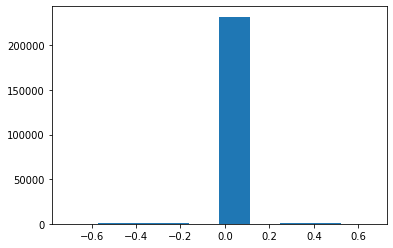

In [151]:
plt.hist(sent_xyz[3],bins=10)